## Load Cell Calibration Optimization Model

Allicia Moeller  
Fall 2024

--------------

In [1]:
! pip install numpy pandas matplotlib seaborn

In [2]:
import sys
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from gamspy import (
    Container,Set,Alias,Parameter,Variable,Equation,Model,Problem,Sense,Options,
    Domain,Number,Sum,Product,Smax,Smin,Ord,Card,SpecialValues,
)
import gamspy.math as gpm

options = Options(equation_listing_limit=100)
m = Container(options=options)

### Background

 **What is the issue being addressed?**
 
 My senior design project for BME 400 involves designing force plates for the foot-stretchers of a rowing machine to display real-time force output of the left and right lower extremities. Each plate has four load cells that convert mechanical force into electrical signals. Due to varying proportionality coefficients (force/voltage) among load cells, a 5-point calibration for each individual load cell before installation into the plate is recommended, necessitating a separate calibration system and annual recalibration. To reduce steps in development and maintenance of our prototype, I want to make an optimization model that assigns best-fit proportionality constants to each of the 4 load cells after they are built into the force plate. 

$$
\text{loadcell} = [a, b, c, d]
$$

$$
adc_{\text{loadcell}} = \text{measure load cell voltage converted in digital adc value}
$$

$$
k_{\text{loadcell}} = \text{proportionaly constant (lb / adc value)}
$$

$$
\text{Total force on plate} = adc_{a} * k_{a} + adc_{b} * k_{b} + adc_{c} * k_{c} + adc_{d} * k_{d}
$$

**How will the model be used?**

Next semester, when construction of the force plates is completed, we will install all the load cells, then place an object of known mass on force plate and record adc values from each of the 4 load cells. The object will be moved around to 5 different spots on the force plate (to vary the force distribution across the load cells) and the adc vlaues will be be recorded. This process will be repeated with 5 different weights. Then, I will run the model on the adc values and known total weight data to backsolve for the optimal proportionality coefficients $k_{\text{loadcell}}$ so that we can accurately calulate total force on the plate from measured load cell adc values.

### Approach

The set of equations gained from data generation will be of the form $Ax = b$

**A** = adc values  
**x** = $k_{\text{loadcell}}$  
**b** = known total weight


where **A** has the dimensions: [m = number of trials, n = number of load cells (4)]

As described above, there will be 5 different weights moved to 5 different spots, so there will 5*5 = 25 trials. Because m > n, the linear system $Ax = b$ is overdefined, and there is likely no solution for x.

I will introduce a residual term **r** to the linear equation such that $Ax - b = r$ so that we can find the best possible solution for **x** by minimizing residuals.

I will test multiple different loss functions with the residual term **r** with test data to determine which is the most effective.

Loss functions:
- Minimax model ($\infty$-norm)
- Minimize the sum of $|r|$ (1-norm)
- Least squares model (2-norm)
- k-norm model
- Huber model


### Test Data Generation


The purpose of this optimization model is to effectively backsolve for individual load cell calibration coefficients in terms of lb/adc value. In order to test the effectivness of the model, I will choose load cell coefficients, create adc test data from those values, inject noise into the test data, then evaluate how well the model solves for the original load cell coefficients.

**Test data load cell coefficient selection:**

I will generate realistic load cell coefficients based on the characteristics of load cell amplification circuitry.

The raw voltage output of the load cell increases by approximately **1 mV per pound** of applied force. This voltage is then amplified using a non-inverting amplifier with a gain of approximately **23 V/V**. The amplified signal is converted from analog to digital using a **12-bit ADC (analog-to-digital converter)**. A 12-bit ADC provides $2^{12} = 4096$ discrete steps between 0 and the supply voltage of 5V.

The ideal load cell calibration coefficient can be derived as follows:

$$
\text{Ideal calibration coefficient} = \frac{1 \, \text{lb}}{0.001 \, \text{V} \cdot 23 \, \text{V/V}} \cdot \frac{5 \, \text{V}}{4096 \, \text{ADC steps}} =  0.053074049 \, \frac{\text{lb}}{\text{ADC step}}
$$

**Sources of coefficient variation:**
1. Every manufactured load cell has slight variations in its force-to-voltage ratio.
2. The gain value of **23 V/V** may also have errors due to resistor mismatches in the amplifier circuit.  

The tolerance of the resistor used in the non-inverting amplifier is 5%, so the tolerance of the gain is +- 1.1 V/V, which means the tolerance of the ideal calibration coefficient is +- 0.002422467. 

$$
\text{(Ideal + tolerance) calibration coefficient} = \frac{1 \, \text{lb}}{0.001 \, \text{V} \cdot 23 + 1.1 \, \text{V/V}} \cdot \frac{5 \, \text{V}}{4096 \, \text{ADC steps}} = 0.050651582
$$
$$
0.053074049 - 0.050651582 = 0.002422467
$$

I do not have an empirical way to predict the manufactured load cell coefficient variation, so I will solely use +- 0.002422467 as the tolerance.


In [3]:
def coefficient_generator(mean_val, tolerance):
    coefficient_list = np.random.rand(1,4) * 2*tolerance - tolerance + mean_val
    return coefficient_list.tolist()[0]

np.random.seed(42) # set seed to save random value
coefficients = coefficient_generator(mean_val = 0.053074049, tolerance = 0.002422467)
print(coefficients)

[0.05246620415616762, 0.05525773006741182, 0.0541980443364761, 0.053552042844474686]


**ADC test data generation:**

The known weight on the force plate is distributed between the 4 load cells. In order to model this, I will generate a [25 x 4] array random numbers from a normal distribution (to represent moving the weight to random spot on the plate, changing the distribution), then scale them so that their sum equals the total known total weight for each trial. This array will represent the actual amount of weight on each load cell. 

I will then divide these force values by my selected coefficients (see above) to convert them into ideal ADC values. Then, I will add noise to this data to represent sources of error in adc measurement and feed this [25 x 4] array of values into my model as matrix **A**.

Real-world sources of error in adc measurement:
- Load cell non-linearity and hysteresis
- Electrical noise
- Capacitor charging delays
- Shear load signal distortion of the load cells

**Noise predictions:**
I cannot predict the amount of noise that each source of error will add into the adc measurement, but I will overcompensate for other sources of error by modeling noise as a +/- 5 mV tolerance on the amplified voltage output (this is an over-estimate).

$$
\text{adc noise tolerance} = 0.005 \text{V} * \frac{4096 \text{ adc value}}{5\text{V}} = 4.096 \text{ adc value}
$$


In [4]:
def test_data_generator(coefficients, noise_tolerance):
    test_df = pd.DataFrame()
    test_df[['rand_a', 'rand_b', 'rand_c', 'rand_d']] = np.random.rand(25,4)
    test_df['Total random'] = test_df[['rand_a', 'rand_b', 'rand_c', 'rand_d']].sum(axis=1)
    test_df['Total Weight'] = [x for x in [40, 80, 120, 160, 200] for _ in range(5)]
    test_df[['rand_a_lbs', 'rand_b_lbs', 'rand_c_lbs', 'rand_d_lbs']] = test_df[['rand_a', 'rand_b', 'rand_c', 'rand_d']].multiply(test_df['Total Weight']/test_df['Total random'], axis=0)
    coefficients_series = pd.Series(coefficients, index=['rand_a_lbs', 'rand_b_lbs', 'rand_c_lbs', 'rand_d_lbs'])
    adc_vals = test_df[['rand_a_lbs', 'rand_b_lbs', 'rand_c_lbs', 'rand_d_lbs']] / coefficients_series
    test_df[['adc_a', 'adc_b', 'adc_c', 'adc_d']] = np.array(adc_vals)
    test_df = test_df.drop(columns=['rand_a', 'rand_b', 'rand_c', 'rand_d','Total random', 'rand_a_lbs', 'rand_b_lbs', 'rand_c_lbs', 'rand_d_lbs'])
    noise = np.random.rand(25,4) * 2 *noise_tolerance - noise_tolerance
    test_df[['adc_a', 'adc_b', 'adc_c', 'adc_d']] += noise
    return test_df

np.random.seed(42)
df = test_data_generator(coefficients=coefficients, noise_tolerance=4.096)

display(df.head(10))

,Total Weight,adc_a,adc_b,adc_c,adc_d
0,40,103.675674,260.239387,201.888606,168.434605
1,40,99.553717,89.286398,33.940790,525.423693
2,40,197.061266,219.417623,4.883800,312.251557
3,40,453.623276,111.536139,96.264433,100.199399
4,40,151.925247,242.160935,208.598973,140.467644
5,80,664.252554,146.489338,304.374517,385.000844
6,80,353.452375,580.813451,153.351389,395.866021
7,80,633.470163,47.549045,632.223449,177.507144
8,80,32.463871,491.415872,514.874975,431.714598
9,80,304.392524,94.286797,660.436143,434.561535


### Optimization Model

In [5]:
# Load data
adc_df = df[['adc_a', 'adc_b', 'adc_c', 'adc_d']]
weight_series = df['Total Weight']

# Sets
row = Set(m,'row',records=df.index)
load_cell = Set(m, 'load_cell', records=adc_df.columns)

# Parameters
A = Parameter(m,'A',domain=[row,'*'],records=adc_df,uels_on_axes=True, description='ADC values for each load cell')
b = Parameter(m, 'b', domain=[row], records=weight_series, uels_on_axes=True, description='total known weight on the force plate')

# Variables
x = Variable(m, 'x', 'positive', domain=[load_cell], description='load cell coefficients')
r = Variable(m, 'r', 'free', domain=[row], description='residuals')
abs_r = Variable(m, 'abs_r', 'positive', domain=[row], description='absolute value of residuals')

# Equations
eqn = Equation(m, 'eqn', domain=[row])
eqn[row] = Sum(load_cell, A[row,load_cell]*x[load_cell]) + r[row] == b[row]

abs_eqn_pos = Equation(m, 'abs_eqn_pos', domain=[row])
abs_eqn_pos[row] = abs_r[row] >= r[row]

abs_eqn_neg = Equation(m, 'abs_eqn_neg', domain=[row])
abs_eqn_neg[row] = abs_r[row] >= -r[row]

Loss Function 1: Minimax Model

In [6]:
# Minimax Model - LP minimizes the maximum error

z = Variable(m,'z','free',description='Auxiliary var for maximum')

zdef_eq = Equation(m,'zdef_eq',domain=[row])
zdef_eq[row]= z >= abs_r[row]

minimax = Model(m,"minimax",
    equations=[eqn, abs_eqn_pos, abs_eqn_neg, zdef_eq],
    problem=Problem.LP,
    sense=Sense.MIN,
    objective=z
)

minimax.solve()
minimax_x = list(x.toDense())
minimax_r = r.toDense()

x.records

,load_cell,level,marginal,lower,upper,scale
0,adc_a,0.052236,0.0,0.0,inf,1.0
1,adc_b,0.055430,0.0,0.0,inf,1.0
2,adc_c,0.054164,0.0,0.0,inf,1.0
3,adc_d,0.053794,0.0,0.0,inf,1.0


Loss Function 2: Minimize the sum of $|r|$ (1-norm)

In [7]:
#LP minimizes the sum of the absolute value of errors

total_abs_error = Sum(row, abs_r[row])

l1_error = Model(m,"l1_error",
    equations=[eqn, abs_eqn_pos, abs_eqn_neg],
    problem=Problem.LP,
    sense=Sense.MIN,
    objective=total_abs_error
)

l1_error.solve()
l1_x = list(x.toDense())
l1_r = r.toDense()
x.records

,load_cell,level,marginal,lower,upper,scale
0,adc_a,0.052300,0.0,0.0,inf,1.0
1,adc_b,0.055325,0.0,0.0,inf,1.0
2,adc_c,0.054353,0.0,0.0,inf,1.0
3,adc_d,0.053536,0.0,0.0,inf,1.0


Loss Function 3: Least squares model (2-norm)


In [8]:
# Minimum Square Error Model - QCP minimizes the sum of the squares of errors

total_error = 0.5 * Sum(row, gpm.sqr(r[row]))

min_SSE = Model(m,"min_SSE",
    equations=[eqn],
    problem=Problem.QCP,
    sense=Sense.MIN,
    objective=total_error
)

min_SSE.solve()
l2_x = list(x.toDense())
l2_r = r.toDense()
x.records

,load_cell,level,marginal,lower,upper,scale
0,adc_a,0.052303,4.353598e-08,0.0,inf,1.0
1,adc_b,0.055274,4.119602e-08,0.0,inf,1.0
2,adc_c,0.054297,4.193735e-08,0.0,inf,1.0
3,adc_d,0.053619,4.246715e-08,0.0,inf,1.0


Loss Function 4: k-norm Model

In [9]:
# arbitraliy set k to 3

# the k-norm model sums the absolute values of the k largest residuals

# the dual formulation of the k-norm model:

k = m.addParameter('k',records=25) 

p = m.addVariable('p','positive',domain=row)
q = m.addVariable('q','positive',domain=row)
u = m.addVariable('u','positive',domain=row)
v = m.addVariable('v','positive',domain=row)
w = m.addVariable('w','positive')

rdef = m.addEquation('rdef', domain=row)
rdef[row] = p[row] - q[row] + u[row] - v[row] == r[row]

defn = m.addEquation('defn', domain=row)
defn[row] = -u[row] - v[row] + w == 0

knorm = m.addModel('knorm',
    equations=[eqn,rdef,defn],
    problem=Problem.LP,
    sense=Sense.MIN,
    objective=Sum(row, p[row] + q[row]) + k*w
)

knorm.solve(output=None)
x.records

,load_cell,level,marginal,lower,upper,scale
0,adc_a,0.052300,0.0,0.0,inf,1.0
1,adc_b,0.055325,0.0,0.0,inf,1.0
2,adc_c,0.054353,0.0,0.0,inf,1.0
3,adc_d,0.053536,0.0,0.0,inf,1.0


**Tuning parameter: k**

I adjust the tuning parameter k by trying 25 different values for k and calculating the RMSE (root mean squared error) between the set coefficients and the coefficients predicted by the k-norm model. Then, I save the k value of the lowest RMSE to rerun my k-norm model.

Note: The k-norm model with k=1 is equivalent to the minimax model, and the k-norm model with k=25 is equivalent to the 1-norm model

In [10]:
k_list = []
rmse_list = []

for n in range(1,25):
    k.setRecords(n)
    knorm.solve()
    predicted = x.toDense()
    sq_err = [(coefficients[i] - predicted[i])**2 for i in range(4)]
    rmse = math.sqrt(0.25*sum(sq_err))
    k_list.append(n)
    rmse_list.append(rmse)

min_knorm_rmse = min(rmse_list)
min_k = (k_list[rmse_list.index(min_knorm_rmse)])

k.setRecords(min_k)
knorm.solve()
k_norm_r = r.toDense()

print("Minimum RMSE k value: ", min_k)

Minimum RMSE k value:  17


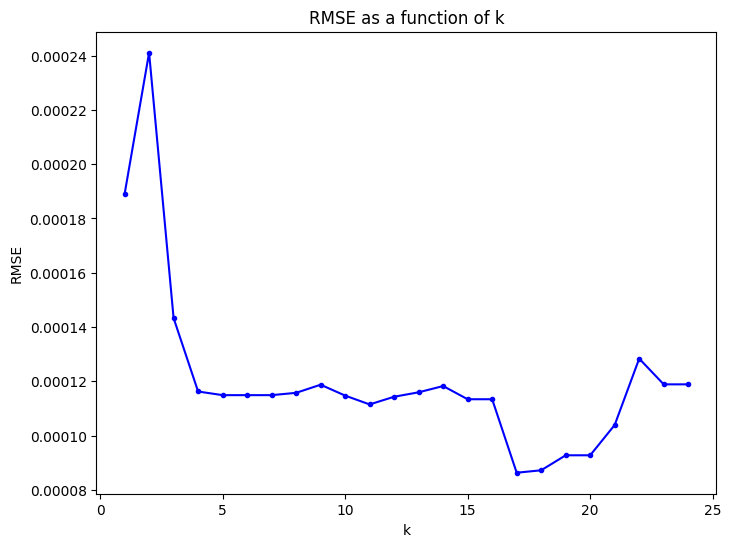

In [11]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title("RMSE as a function of k")
ax.set_xlabel("k")
ax.set_ylabel("RMSE")
ax.plot(k_list,rmse_list,"b.-");

Loss Function 5: Huber Model


In [12]:
# Huber model 

# Parameters
sigma = m.addParameter('sigma',description="cutoff for quadratic penalty")

# Variables
t = m.addVariable('t',domain=row,description='residual l_1 error')

# Equations
upp = m.addEquation('upp',domain=row) 
upp[row] = b[row] - Sum(load_cell, A[row,load_cell]*x[load_cell]) - r[row] <= t[row]

low = m.addEquation('low',domain=row) 
low[row] = -t[row] <= b[row] - Sum(load_cell, A[row,load_cell]*x[load_cell]) - r[row]

obj= 0.5*Sum(row, gpm.sqr(r[row])) + sigma*Sum(row, t[row])

hubmod = m.addModel('hubmod',
    equations=[low,upp],
    problem=Problem.QCP,
    sense=Sense.MIN,
    objective=obj)


sigma.setRecords(1) #arbitrarily set sigma to 1

hubmod.solve(options=Options(qcp="conopt"),output=None)

x.records

,load_cell,level,marginal,lower,upper,scale
0,adc_a,0.052303,0.0,0.0,inf,1.0
1,adc_b,0.055274,0.0,0.0,inf,1.0
2,adc_c,0.054297,0.0,0.0,inf,1.0
3,adc_d,0.053619,0.0,0.0,inf,1.0


**Tuning parameter: sigma**

I adjust the tuning parameter sigma by trying 20 different values for sigma and calculating the RMSE (root mean squared error) between the set coefficients and the coefficients predicted by the huber model. Then, I save the sigma value of the lowest RMSE to rerun my huber model.

In [13]:
sig = []
rmse_list = []

for n in np.linspace(0,1,20):
    sigma.setRecords(n)
    hubmod.solve(options=Options(qcp="conopt"),output=None)
    predicted = x.toDense()
    sq_err = [(coefficients[i] - predicted[i])**2 for i in range(4)]
    rmse = math.sqrt(0.25*sum(sq_err))
    sig.append(n)
    rmse_list.append(rmse)

min_huber_rmse = min(rmse_list)
minsigma = (sig[rmse_list.index(min_huber_rmse)])

sigma.setRecords(minsigma)
hubmod.solve(options=Options(qcp="conopt"),output=None)
huber_r = r.toDense()

print("Minimum RMSE sigma value: ", minsigma)

Minimum RMSE sigma value:  0.21052631578947367


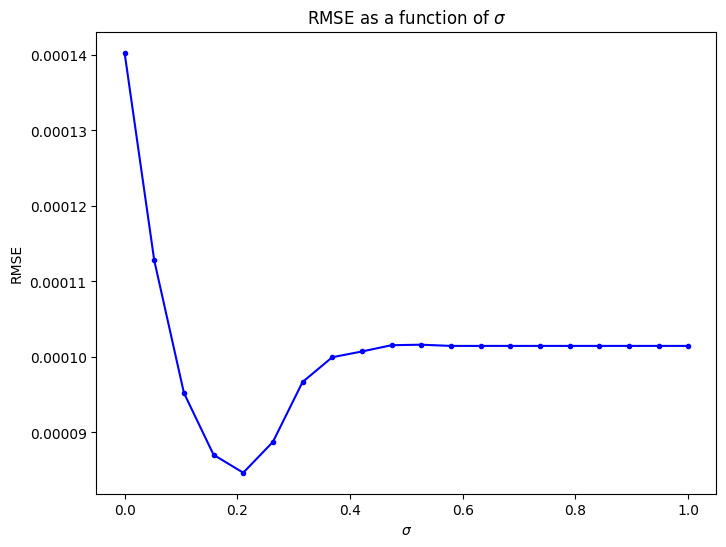

In [14]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,6))
ax.set_title("RMSE as a function of $\\sigma$")
ax.set_xlabel("$\\sigma$")
ax.set_ylabel("RMSE")
ax.plot(sig,rmse_list,"b.-");

In [15]:
# set sigma to tuned sigma value and rerun the huber model

sigma.setRecords(minsigma)
hubmod.solve(options=Options(qcp="conopt"),output=None)

x.records

,load_cell,level,marginal,lower,upper,scale
0,adc_a,0.052328,0.0,0.0,inf,1.0
1,adc_b,0.055323,0.0,0.0,inf,1.0
2,adc_c,0.054262,0.0,0.0,inf,1.0
3,adc_d,0.053589,0.0,0.0,inf,1.0


**Loss Function Comparison**

To compare which loss function performed the best, I will first calculate the root mean square error between the predicted coefficients and actual coefficients for each loss function.

In [16]:
def calculate_rmse(x_predicted, x_actual):
    if len(x_predicted) == len(x_actual):
        sq_err = [(x_actual[i] - x_predicted[i])**2 for i in range(len(x_predicted))]
        rmse = math.sqrt(0.25*sum(sq_err))
        return rmse
    
minimax_rmse = calculate_rmse(minimax_x, coefficients)
l1_rmse = calculate_rmse(l1_x, coefficients)
l2_rmse = calculate_rmse(l2_x, coefficients)

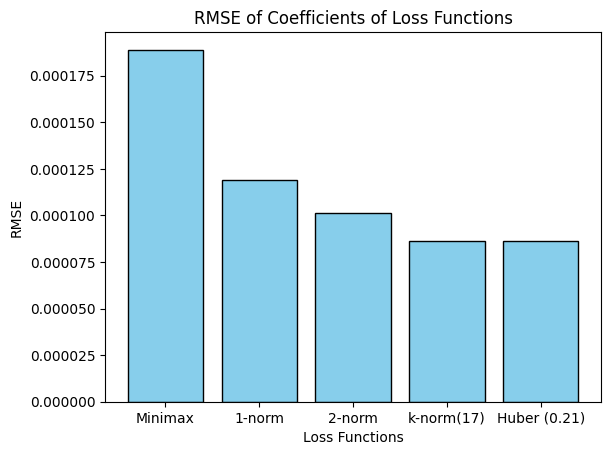

In [17]:
%matplotlib inline

loss_functions = ['Minimax', '1-norm', '2-norm', f'k-norm({min_k})', f'Huber ({round(minsigma,2)})']
rmse_vals = [minimax_rmse, l1_rmse, l2_rmse, min_knorm_rmse, min_knorm_rmse]

plt.bar(loss_functions, rmse_vals, color='skyblue', edgecolor='black')
plt.xlabel('Loss Functions')
plt.ylabel('RMSE')
plt.title('RMSE of Coefficients of Loss Functions')

plt.show()

All the loss functions perform relatively well but the k-norm (17) and Huber (0.21) model seem to perform the best in accurately predicting the load cell coefficients.

Next, I will plot boxplots of the residuals of each loss function, which is the difference between the actual force on the plate during a given trial, and the force calculated by the coefficients generated from the model.

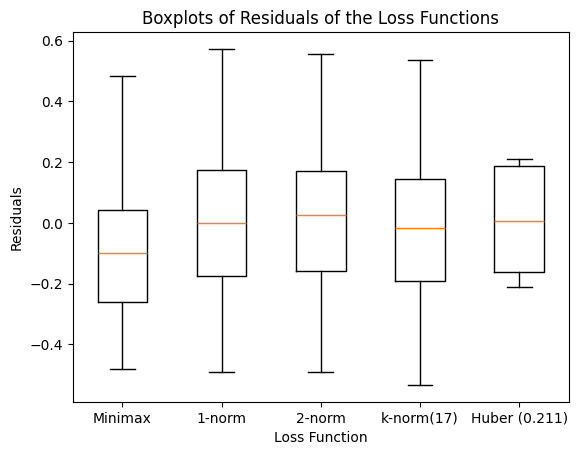

In [18]:
loss_functions = ['Minimax', '1-norm', '2-norm', f'k-norm({min_k})', f'Huber ({round(minsigma,3)})']
data = [minimax_r, l1_r, l2_r, k_norm_r, huber_r]

plt.boxplot(data)
plt.xticks([1, 2, 3, 4, 5], loss_functions)
plt.title('Boxplots of Residuals of the Loss Functions')
plt.xlabel('Loss Function')
plt.ylabel('Residuals')

plt.show()

The boxplots show that the Huber ($\sigma$ = 0.21) model has the smallest range in residual values, and its residuals are tightly centered around 0. This may indicate that the Huber ($\sigma$ = 0.21) model is the best model for this project.

To analyze the residuals on a trial-by-trial basis, rather than as a distribution, I will display a line plot of the residuals by trial for each loss function.

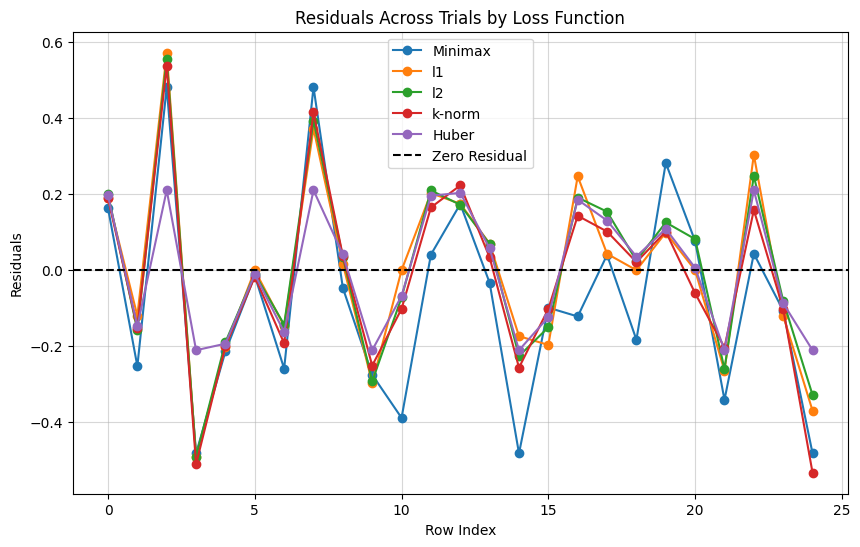

In [19]:
rows = np.arange(len(minimax_r))

plt.figure(figsize=(10, 6))
plt.plot(rows, minimax_r, label='Minimax', marker='o')
plt.plot(rows, l1_r, label='l1', marker='o')
plt.plot(rows, l2_r, label='l2', marker='o')
plt.plot(rows, k_norm_r, label='k-norm', marker='o')
plt.plot(rows, huber_r, label='Huber', marker='o')
plt.axhline(0, color='black', linestyle='--', label='Zero Residual')
plt.xlabel('Row Index')
plt.ylabel('Residuals')
plt.title('Residuals Across Trials by Loss Function')
plt.legend()
plt.grid(alpha=0.5)
plt.show()


The residual line plot shows that some loss function residuals stay closer to 0 than others, but the plot is a bit hard to analyze with so many overlapping lines. To visualize this same concept differently, I will make a heat map that describes residual values by trial for each loss function.

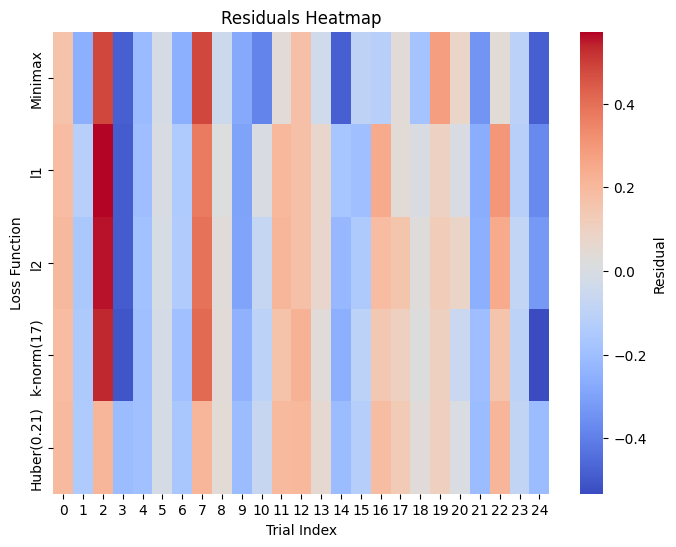

In [20]:
import seaborn as sns

# Combine residuals into a DataFrame
residuals_df = pd.DataFrame({'Minimax': minimax_r, 'l1': l1_r, 'l2': l2_r, f'k-norm({min_k})': k_norm_r, f'Huber({round(minsigma,2)})': huber_r})

plt.figure(figsize=(8, 6))
sns.heatmap(residuals_df.T, annot=False, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Residual'})
plt.xlabel('Trial Index')
plt.ylabel('Loss Function')
plt.title('Residuals Heatmap')
plt.show()


Like the box plot, the residual heat map shows that the Huber ($\sigma$ = 0.21) model has consistently small residuals.

**Sensitivity Analysis**

In order to see how resistant each model is to noise, I will perturb the adc values (matrix **A**) with varying levels of noise, run each loss function model, and plot the RMSE of actual vs predicted coefficients.

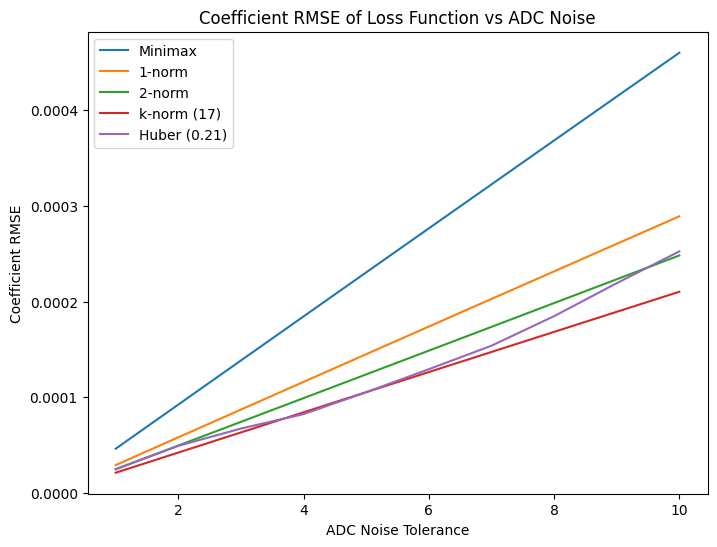

In [21]:
%matplotlib inline

rmse_dict = {'Minimax': [], '1-norm': [], '2-norm': [], f'k-norm ({min_k})': [], f'Huber ({round(minsigma, 2)})': []}

noise_range = [i for i in range(1,11)]

for i in noise_range:
    np.random.seed(42)
    df = test_data_generator(coefficients=coefficients, noise_tolerance=i)

    adc_df = df[['adc_a', 'adc_b', 'adc_c', 'adc_d']]
    weight_series = df['Total Weight']
    A = Parameter(m,'A',domain=[row,'*'],records=adc_df,uels_on_axes=True, description='ADC values for each load cell')
    b = Parameter(m, 'b', domain=[row], records=weight_series, uels_on_axes=True, description='total known weight on the force plate')

    minimax.solve()
    rmse_dict['Minimax'].append(calculate_rmse(list(x.toDense()), coefficients))

    l1_error.solve()
    rmse_dict['1-norm'].append(calculate_rmse(list(x.toDense()), coefficients))

    min_SSE.solve()
    rmse_dict['2-norm'].append(calculate_rmse(list(x.toDense()), coefficients))

    k.setRecords(min_k)
    knorm.solve()
    rmse_dict[f'k-norm ({min_k})'].append(calculate_rmse(list(x.toDense()), coefficients))

    sigma.setRecords(minsigma)
    hubmod.solve()
    rmse_dict[f'Huber ({round(minsigma, 2)})'].append(calculate_rmse(list(x.toDense()), coefficients))


plt.figure(figsize=(8, 6))
for label, y_values in rmse_dict.items():
    plt.plot(noise_range, y_values, label=label)

plt.xlabel('ADC Noise Tolerance')
plt.ylabel('Coefficient RMSE')
plt.title('Coefficient RMSE of Loss Function vs ADC Noise')
plt.legend()

plt.show()

The sensitivity analysis revealed that the k-norm(17) loss function was the most resistant to noise variation. The Huber ($\sigma$ = 0.21) model was about as resistant to noise as the k-norm model until the noise maximum tolerance reached 7 adc values, then it increased.

### Conclusion

Based on the comparison of the loss functions and the sensitivity analysis, I conclude that the Huber model ($\sigma$ = 0.21) is the best loss function to use to accurately and consistently solve for load cell calibration coefficients. Even though the Huber loss function showed an increase in RMSE at higher noise levels, it is not likely that measurements will reach noise levels that high. Furthermore, the Huber loss function residual range was smaller than all the other loss functions (see boxplots) and closely centered around 0, which means that it is capable of solving for coefficients that will calculate accurate and consistent force values.

### Going Further

Next semester, my team will finish the force plates, and we will be able to use this optimization model to backsolve for load cell calibration coefficients. We will also test for force measurement accuracy with calibrated weights, which may inform the effectiveness of this model in a real-world application. Futhermore, the load cell manufacturer we used recommends that the load cells are recalibrated annually. With this optimization model, we could build a guided, user-friendly calibration protocol with no need to disassemble the plate and calibrate each load cell individually.